## Modules à importer

In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNF')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

def set_data(su):
    global ns_dataz, dataz, ns_datax, datax
    if su == 'SNF':
        ns_dataz = surv[su]['host.zcmb'].values
        dataz = np.sort(ns_dataz)
        ns_datax = surv[su]['salt2.X1'].values
        datax = np.sort(ns_datax)
    else:
        ns_dataz = surv[su].zCMB.values
        dataz = np.sort(ns_dataz)
        ns_datax = surv[su].x1.values
        datax = np.sort(ns_datax)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=4, options=('SDSS', 'SNLS', 'PS1', 'HST', 'SNF'), …

## Choix des bins pour les listes de redshifts et de strech

In [3]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Définitions des dictionnaires généraux : $z < z_{\text{max}}$ cuts pour $z$ et $x_1$

In [4]:
zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()

for survey in surveys[:-1]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]

## Utilisation de la classe _stretchevol_ pour le fit double

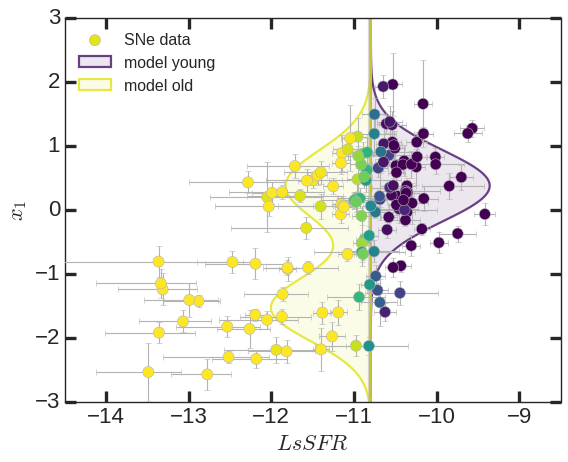

In [52]:
reload(stretchevol)

names = {'lssfr_name':       'lssfr',
         'stretch_name':     'salt2.X1',
         'stretch_err_name': 'salt2.X1.err',
         'lssfr_err_d_name': 'lssfr.err_down',
         'lssfr_err_u_name': 'lssfr.err_up',
         'py_name':          'p(prompt)'}

evolD = stretchevol.EvolDouble()
evolD.set_names(names)
evolD.set_data(d_snf)

evolD.minimize()

evolD.plt_scatter()

fig=plt.gcf()
fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

## Utilisation de _stretchevol_ pour le _mock_

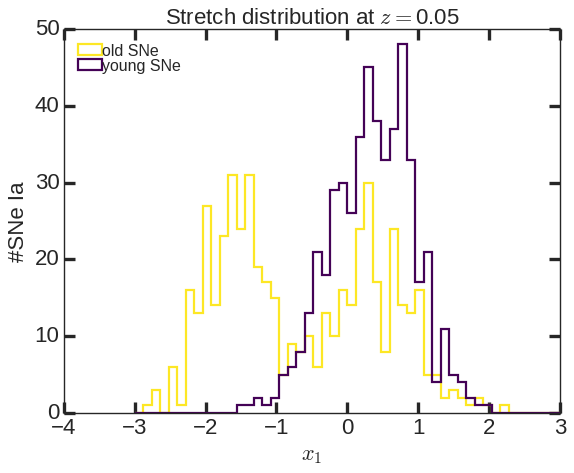

In [42]:
reload(stretchevol)

mockD = stretchevol.MockEvol()

mockD.set_values(evolD.param)
mockD.set_data(0.05, 1000)

mockD.solver()
mockD.plotter(50, [-3,3])

## Définition des dictionnaires généraux : mean et std

In [38]:
z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

## Utilisation du _mock_ sur large bande de redshifts

In [39]:
def get_stretch_sample(redshift, npoints, shuffle=True):
    mock = stretchevol.MockEvol()
    mock.set_values(evolD.param)
    mock.set_data(redshift, npoints)
    mock.solver()
    mockx = np.concatenate((mock.x1_o,mock.x1_y))
    if shuffle:
        np.random.shuffle(mockx)
    return mockx

In [40]:
zz = np.linspace(0, 1.4, 200)
x1_z = np.asarray([get_stretch_sample(z_, 100000) for z_ in zz])

low_x1 = np.asarray([len(x_[x_<-.5])/len(x_) for x_ in x1_z])

## Détermination loi analytique

In [43]:
def mock_law(z, a, b):
    return a*mockD.delta(z) + b

def mock_law_min(a, b):
    return np.sqrt(np.sum((mock_law(zz, a, b) - np.mean(x1_z, axis=1))**2))

m_mock = im.Minuit(mock_law_min,
                   b = -0.6, a = 1,
                   print_level=1, pedantic=False)

m_mock.migrad();

FCN = 0.025610398607488774 
 TOTAL NCALL = 48 
 NCALLS = 48 
 
 
 EDM = 7.882936969101935e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.996702,0.12531,,,,,No
1,b,-0.609798,0.0963011,,,,,No


## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$ + _mock_

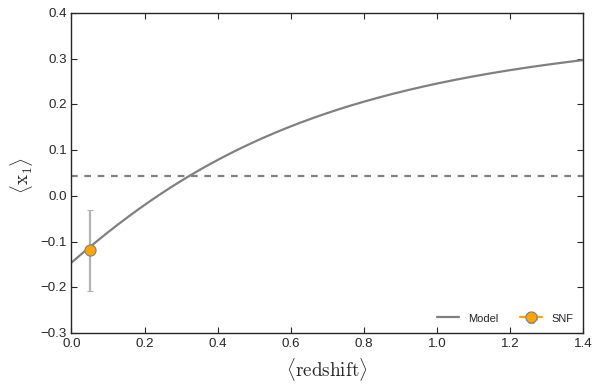

In [49]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
for i in range(5):
    if i != 4:
        continue
    ax.errorbar(list(z_mean.values())[i], list(x1_mean.values())[i],
                 xerr = list(z_std.values())[i]/np.sqrt(len(list(z_zcuts.values())[i])),
                 yerr = list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])), 
                 color = list(colors.values())[i], label = surveys[i], **prop)

    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline( np.mean(list(x1_mean.values()) ), lw=2, ls="--", color="0.5")

ax.plot(zz, mock_law(zz, m_mock.values['a'], m_mock.values['b']),
        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig.savefig('/home/nora/Pictures/stretchevol_onlysnf.pdf')

## Calcul du $\chi²$

In [81]:
chi2_hline = 0
for i in range(5):
    chi2_hline += (list(x1_mean.values())[i] - np.mean(np.asarray(list(x1_mean.values()))))**2\
                    / (list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])))**2
    
chi2_model = 0
for i in range(5):
    chi2_model += (list(x1_mean.values())[i] - mock_law(np.asarray(list(z_mean.values())[i]),
                                                          m_mock.values['a'],
                                                          m_mock.values['b']))**2\
                    / (list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])))**2

delta_chi2 = chi2_hline - chi2_model

display(Latex("$\chi²_{\mathrm{hline}}$ = %5f " % chi2_hline))
display(Latex("$\chi²_{\mathrm{model}}$ = %5f " % chi2_model))
display(Latex("$\Delta\chi²$ = %5f " % delta_chi2))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Définition des dictionnaires généraux : $x_1 < -0.5$ cuts

In [19]:
xmax_cuts = dict()
x1_xcuts = dict()
z_xcuts = dict()

for survey in surveys:
    xmax_cuts[survey] = np.where(x1_zcuts[survey] < -.5)
    x1_xcuts[survey] = x1_zcuts[survey][xmax_cuts[survey]]
    z_xcuts[survey] = z_zcuts[survey][xmax_cuts[survey]]

## Tracé de la fraction de SNe de $x_1 < -0.5$ en fonction de $z_{\text{mean}}$ et modèle

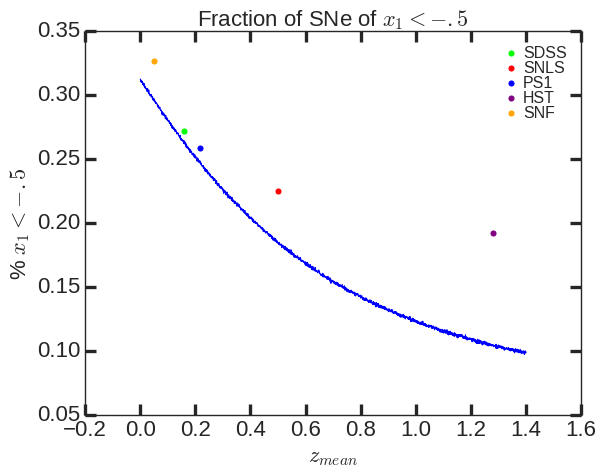

In [76]:
#plt.style.use('dark_background')
plt.style.use(['classic', 'seaborn-white'])

for i in range(5):
    plt.scatter(z_mean[surveys[i]], len(x1_xcuts[surveys[i]])/len(x1_zcuts[surveys[i]]),
                color = colors[surveys[i]], label = surveys[i])

plt.plot(zz, low_x1)
    
ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{mean}$', fontsize = 20)
plt.ylabel('% $x_1 < -.5$', fontsize = 20)

plt.legend(ncol=1, loc='upper right', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Fraction of SNe of $x_1 < -.5$', fontsize = 20)

plt.show()

# DÉTERMINATION ÉVOLUTION SIMPLE DU STRETCH

## Définition des dictionnaires généraux : LsSFR, stretch, erreurs et Py

In [82]:
lssfr = dict()
lssfr_err_d = dict()
lssfr_err_u = dict()
x1_err = dict()
py = dict()

lssfr_med = -10.8

for survey in surveys[4:5]:
    lssfr[survey] = surv[survey]['lssfr'].values
    lssfr_err_d[survey] = surv[survey]['lssfr.err_down'].values
    lssfr_err_u[survey] = surv[survey]['lssfr.err_up'].values
    x1_err[survey] = surv[survey]['salt2.X1.err'].values
    py[survey] = surv[survey]['p(prompt)'].values

## Définition dictionnaires spécifiques : lssfr et stretch young/old simple

In [89]:
lssfr_med = -10.8 #fixe K dans l'article RIGAULT et. al 2018

d_snf_y = d_snf.loc[d_snf['lssfr']>lssfr_med]
lssfr_y = d_snf_y['lssfr']
x1_y = d_snf_y['salt2.X1']
x1_y_err = d_snf_y['salt2.X1.err']

d_snf_o = d_snf.loc[d_snf['lssfr']<lssfr_med]
lssfr_o = d_snf_o['lssfr']
x1_o = d_snf_o['salt2.X1']
x1_o_err = d_snf_o['salt2.X1.err']

## Définition du modèle à minimiser et minimisation

In [91]:
def gauss(x, dx, mu, sigma):
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

def loglikelihood_y(mu_y, sigma_y):
    return -2*np.sum(np.log(gauss(x1_y, x1_y_err, mu_y, sigma_y)))

def loglikelihood_o(mu_o, sigma_o):
    return -2*np.sum(np.log(gauss(x1_o, x1_o_err, mu_o, sigma_o)))

m_y = im.Minuit(loglikelihood_y, mu_y=0, sigma_y=1,
                print_level=0, pedantic=False)
m_o = im.Minuit(loglikelihood_o, mu_o=0, sigma_o=1,
                print_level=0, pedantic=False)

m_y.migrad()
m_o.migrad()

print()

## Tracé de $x_1$ en fonction du $LsSFR$ pour SNF

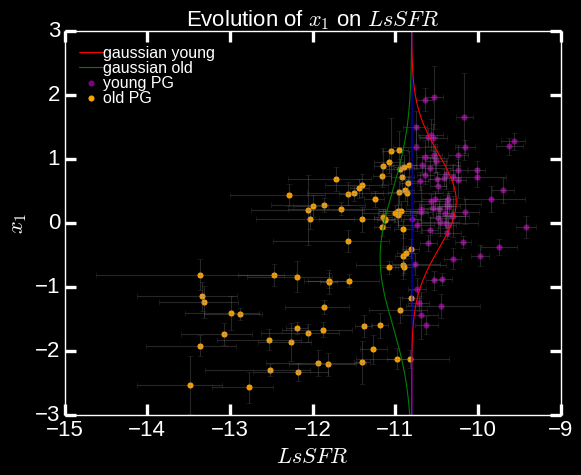

In [92]:
plt.style.use('dark_background')
#plt.style.use('seaborn-white')

plt.scatter(lssfr_y, x1_y, marker = 'o', s = 20,
            color = colors['HST'], label='young PG')
plt.scatter(lssfr_o, x1_o, marker = 'o', s = 20,
            color = colors['SNF'], label='old PG')

plt.errorbar(lssfr['SNF'], x1_zcuts['SNF'],
             xerr = [lssfr_err_d['SNF'], lssfr_err_u['SNF']],
             yerr = x1_err['SNF'],
             ecolor = 'gray',
             alpha = .3,
             ls='none')

plt.plot([lssfr_med,lssfr_med], [-3,3], color = 'b', alpha = .5, linewidth=2.0)

x_linspace = np.linspace(-3,3,1000)

plt.plot(gauss(x_linspace, 0, m_y.values['mu_y'], m_y.values['sigma_y'])+lssfr_med,
         x_linspace, color = 'r', label='gaussian young')
plt.plot(-gauss(x_linspace, 0, m_o.values['mu_o'], m_o.values['sigma_o'])+lssfr_med,
         x_linspace, color = 'g', label='gaussian old')

ax = plt.gca()

ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
ax.set_ylim([-3,3])
plt.xlabel('$LsSFR$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

plt.legend(ncol=1, loc='upper left', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Evolution of $x_1$ on $LsSFR$', fontsize = 20)

plt.show()

## Utilisation de la classe $stretchevol$ pour un fit simple du stretch

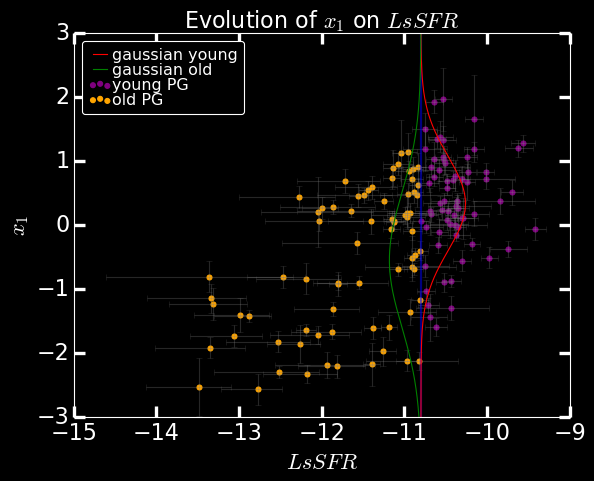

In [67]:
reload(stretchevol)

names = {'lssfr_name':       'lssfr',
         'stretch_name':     'salt2.X1',
         'stretch_err_name': 'salt2.X1.err',
         'lssfr_err_d_name': 'lssfr.err_down',
         'lssfr_err_u_name': 'lssfr.err_up'}

evol = stretchevol.EvolSimple()
evol.set_names(names)
evol.set_data(d_snf)

evol.minimize()

evol.plt_scatter()

## Détermination deux nuages

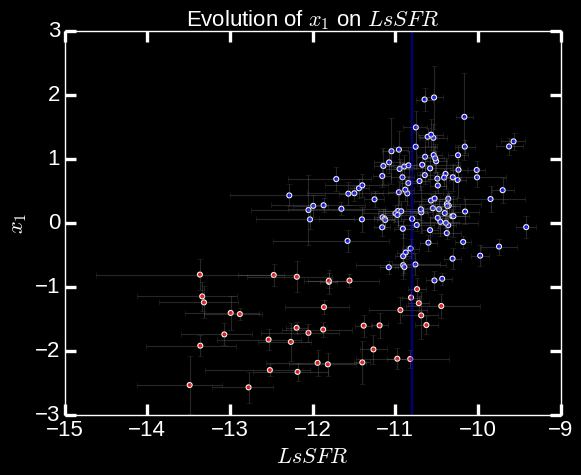

In [94]:
nuage = np.array([lssfr['SNF'], x1_zcuts['SNF']]).T

km = KMeans(2)
km.fit(nuage)

cmap = plt.cm.get_cmap("bwr", km.cluster_centers_.shape[0])
km_colors = [cmap(i) for i in km.fit_predict(nuage)]

plt.style.use('dark_background')
#plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 1)

ax.scatter(nuage[:, 0], nuage[:, 1], c=km_colors)

ax.errorbar(lssfr['SNF'], x1_zcuts['SNF'],
            xerr = [lssfr_err_d['SNF'], lssfr_err_u['SNF']],
            yerr = x1_err['SNF'],
            ecolor = 'gray',
            alpha = .3,
            ls='none')

plt.plot([lssfr_med,lssfr_med], [-3,3], color = 'b', alpha = .5, linewidth=2.0)

ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
ax.set_ylim([-3,3])
plt.xlabel('$LsSFR$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

plt.title('Evolution of $x_1$ on $LsSFR$', fontsize = 20)

plt.show()

red_loc = np.array([bool(i) for i in km.fit_predict(nuage)])
blue_loc = np.array([not i for i in red_loc])

better_lssfr_y = lssfr['SNF'][blue_loc][lssfr['SNF'][blue_loc]>lssfr_med]
better_x1_y    = x1_zcuts['SNF'][blue_loc][lssfr['SNF'][blue_loc]>lssfr_med]

# DÉTERMINATION DOUBLE DE L'ÉVOLUTION DU STRETCH

## Définition des dictionnaires généraux : LsSFR, stretch, erreurs et Py

In [82]:
lssfr = dict()
lssfr_err_d = dict()
lssfr_err_u = dict()
x1_err = dict()
py = dict()

lssfr_med = -10.8

for survey in surveys[4:5]:
    lssfr[survey] = surv[survey]['lssfr'].values
    lssfr_err_d[survey] = surv[survey]['lssfr.err_down'].values
    lssfr_err_u[survey] = surv[survey]['lssfr.err_up'].values
    x1_err[survey] = surv[survey]['salt2.X1.err'].values
    py[survey] = surv[survey]['p(prompt)'].values

## Définition du modèle à minimiser et minimisation

In [84]:
def gauss(x, dx, mu, sigma):
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

def likelihood_y(x, dx, mu_1, sigma_1):
    return gauss(x, dx, mu_1, sigma_1)

def likelihood_o(x, dx, a, mu_1, sigma_1, mu_2, sigma_2):
    return a*gauss(x, dx, mu_1, sigma_1) + (1-a)*gauss(x, dx, mu_2, sigma_2)

def likelihood_tot(py, x, dx, a, mu_1, sigma_1, mu_2, sigma_2):
    return py*likelihood_y(x, dx, mu_1, sigma_1) +\
       (1-py)*likelihood_o(x, dx, a, mu_1, sigma_1, mu_2, sigma_2)

def loglikelihood(a, mu_1, sigma_1, mu_2, sigma_2):
    return -2*np.sum(np.log(likelihood_tot(py['SNF'], x1_zcuts['SNF'],\
                                           x1_err['SNF'], a, mu_1, sigma_1, mu_2, sigma_2)))

m_tot = im.Minuit(loglikelihood, a=.3, mu_1=0, sigma_1=1, mu_2=0, sigma_2=1,
                  limit_a=(0,1),
                  print_level=1, pedantic=False)

m_tot.migrad()
print()

FCN = 349.9860146427362 
 TOTAL NCALL = 230 
 NCALLS = 230 
 
 
 EDM = 1.3639320432879567e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.477226,0.073919,,,0,1,No
1,mu_1,0.386846,0.0675037,,,,,No
2,sigma_1,0.555464,0.0543524,,,,,No
3,mu_2,-1.5206,0.1166,,,,,No
4,sigma_2,0.518949,0.0901523,,,,,No


## Tracé des modèles

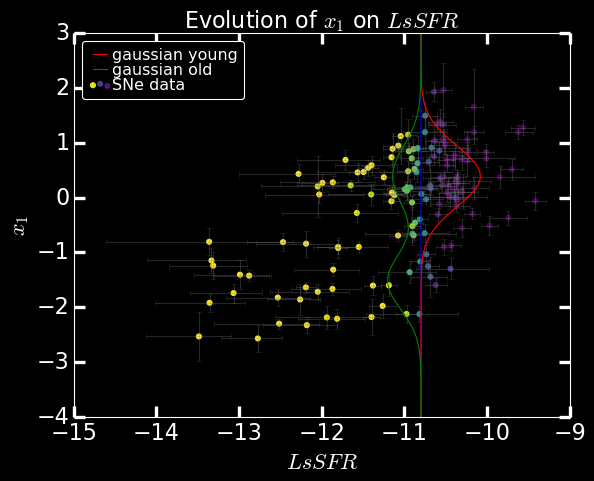

In [89]:
plt.style.use(['classic','dark_background'])
#plt.style.use(['classic','seaborn-white'])

dgmap = plt.cm.get_cmap('viridis')
dg_colors = [dgmap(i) for i in (1-py['SNF'])]

plt.scatter(lssfr['SNF'], x1_zcuts['SNF'], marker = 'o', s = 20,
            color = dg_colors, label='SNe data')


plt.errorbar(lssfr['SNF'], x1_zcuts['SNF'],
             xerr = [lssfr_err_d['SNF'], lssfr_err_u['SNF']],
             yerr = x1_err['SNF'],
             ecolor = 'gray',
             alpha = .3,
             ls='none')

plt.plot([lssfr_med,lssfr_med], [-3,3], color = 'b', alpha = .5, linewidth=2.0)

x_linspace = np.linspace(-5,5,5000)

plt.plot(likelihood_y(x_linspace, 0, m_tot.values['mu_1'], m_tot.values['sigma_1'])+lssfr_med,
         x_linspace, color = 'r', label='gaussian young')
plt.plot(-likelihood_o(x_linspace, 0, m_tot.values['a'],
                       m_tot.values['mu_1'], m_tot.values['sigma_1'],
                       m_tot.values['mu_2'], m_tot.values['sigma_2'])+lssfr_med,
         x_linspace, color = 'g', label='gaussian old')

ax = plt.gca()

ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
ax.set_ylim([-4,3])
plt.xlabel('$LsSFR$', fontsize = 20)
plt.ylabel('$x_1$', fontsize = 20)

plt.legend(ncol=1, loc='upper left', 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Evolution of $x_1$ on $LsSFR$', fontsize = 20)

plt.show()

## Utilisation des modèles pour création d'un _mock_

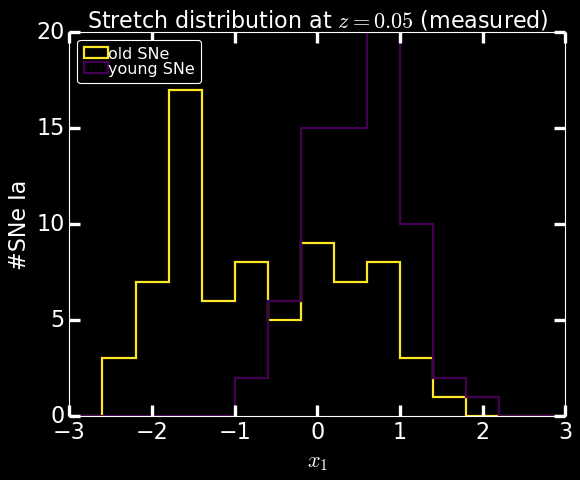

In [120]:
plt.style.use(['classic','dark_background'])
#plt.style.use(['classic','seaborn-white'])

npoints=141

## For "old" SNe Ia
npoints_o=int(npoints/2)
nm1_o = np.random.normal(loc=m_tot.values['mu_1'],
                         scale=m_tot.values['sigma_1'],
                         size=int((npoints_o+5)*(m_tot.values['a'])))
nm2_o = np.random.normal(loc=m_tot.values['mu_2'],
                         scale=abs(m_tot.values['sigma_2']),
                         size=int((npoints_o+5)*(1-m_tot.values['a'])))

n_o = np.concatenate([nm2_o, nm1_o])
np.random.shuffle(n_o)

n_o = n_o[:npoints]


## For "young" SNe Ia
npoints_y=npoints-npoints_o
n_y = np.random.normal(loc=m_tot.values['mu_1'],
                       scale=m_tot.values['sigma_1'],
                       size=npoints_y)

plt.hist(n_o, bins=nb_x.value, range=[-3, 3],
         color=dgmap(256), histtype='step', lw=2,
         label='old SNe')
plt.hist(n_y, bins=nb_x.value, range=[-3, 3],
         color=dgmap(0), histtype='step', lw=2,
         label='young SNe')

ax = plt.gca()

ax.tick_params(axis='both',
               direction='in',
               length=10, width=3,
               labelsize=20,
               which='both',
               top=True, right=True)

ax.set_xlim([-3, 3])

plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('#SNe Ia', fontsize=20)

plt.legend(ncol=1, loc='upper left',
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Stretch distribution at $z=0.05$ (measured)', fontsize=20)

plt.show()

# ANCIENNES CELLULES

## Tracé des redshifts de l'échantill choisi

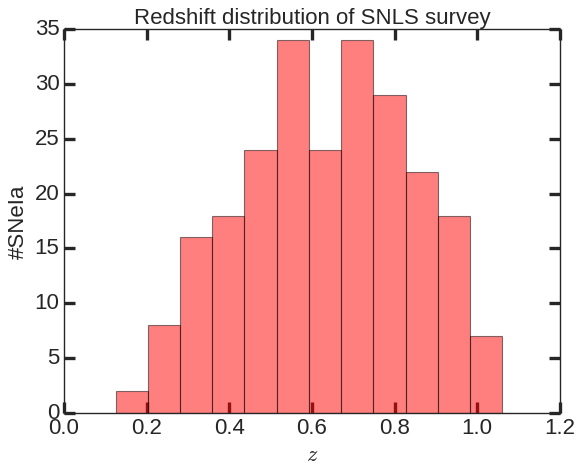

In [7]:
#plt.style.use('dark_background')
plt.style.use(['classic', 'seaborn-white'])

plt.hist(np.sort(ns_dataz), bins = nb_z.value, color = colors[su.value], alpha = .5)

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z$', fontsize = 20)
plt.ylabel('#SNeIa', fontsize = 20)

plt.title('Redshift distribution of ' + str(su.value) + ' survey', fontsize = 20)

plt.show()

## Tracé du strech de l'échantillon choisi, coupé à zmax

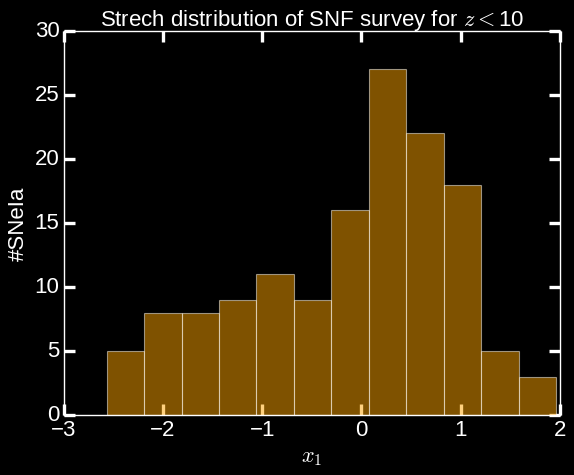

In [97]:
plt.style.use('dark_background')
#plt.style.use('seaborn-white')

cut = np.where(ns_dataz<zmax[su.value])

plt.hist(np.sort(ns_datax[cut]), bins = nb_x.value, color = colors[su.value], alpha = .5)

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('#SNeIa', fontsize = 20)

plt.title('Strech distribution of ' + str(su.value) + ' survey for $z < $' +
           str(zmax[su.value]), fontsize = 20)

plt.show()

## Tracé des strechs cut à $z_{\text{max}}$

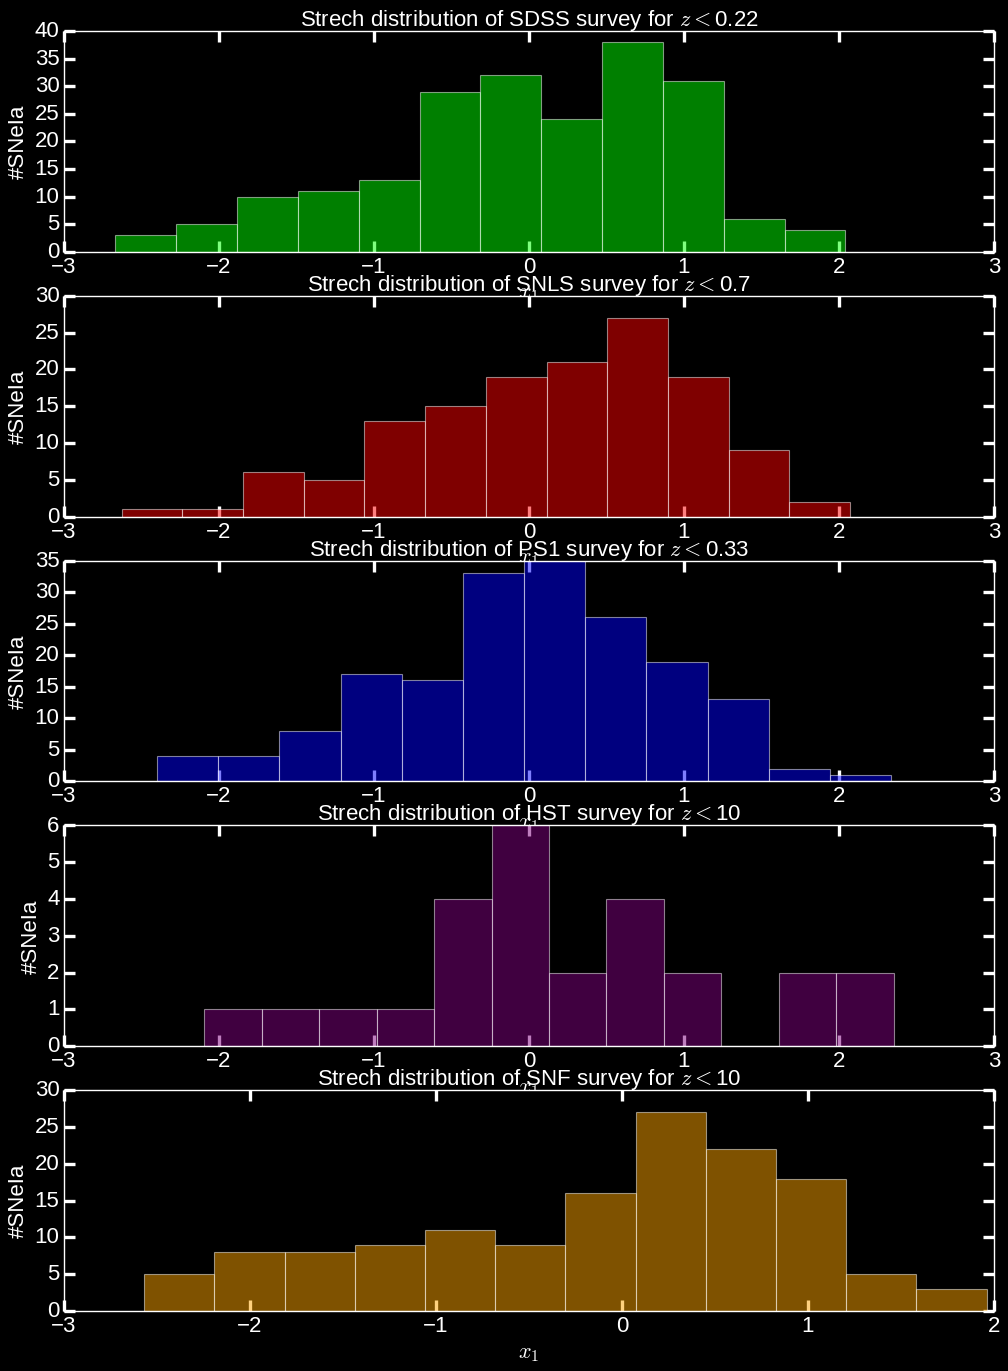

In [12]:
plt.style.use('dark_background')
#plt.style.use('seaborn-white')

plt.figure(figsize = [15,20])

for i in range(len(surveys)):
    plt.subplot(5, 1, i+1)
    plt.hist(x1_zcuts[surveys[i]], bins = nb_x.value, color = colors[surveys[i]], alpha = .5)

    ax = plt.gca()
    ax.tick_params(axis = 'both',
                   direction = 'in',
                   length = 10, width = 3,
                   labelsize = 20,
                   which = 'both',
                   top = True, right = True)
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('#SNeIa', fontsize = 20)

    plt.title('Strech distribution of ' + surveys[i] + ' survey for $z < $' +
              str(list(zmax.values())[i]), fontsize = 20)

plt.show()

# DÉTERMINATION DES $z_{\text{max}}$ _VIA_ BASERATE

## Base model

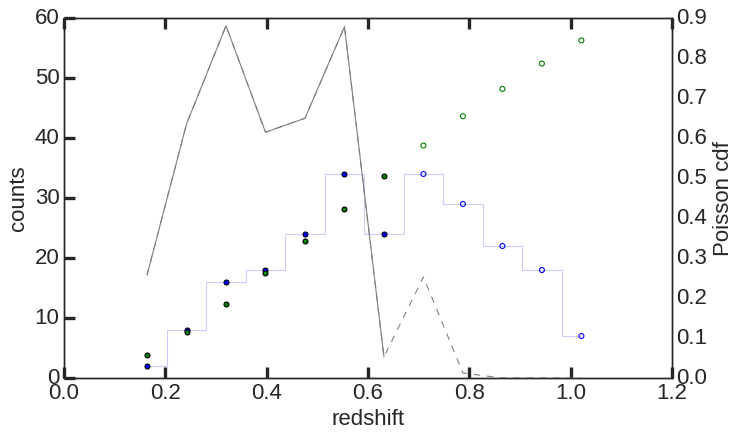

In [135]:
reload(baserate)

base = baserate.VolumeNoModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(base)
ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2)
_ = ratefitter.show(add_proba = True)

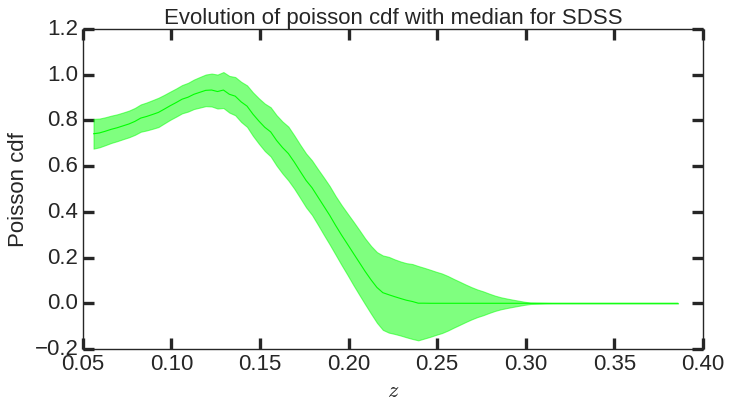

In [109]:
reload(baserate)
baserate.pshow_r(su.value, dataz, 0.2, 100)

## Expo Model

In [174]:
from astropy.cosmology import Planck15 as cosmo
redshiftsA = ratefitter._properties['redshift_ranges'][1]
redshiftsB = ratefitter._properties['redshift_ranges'][0]

flag_upA = redshiftsA > 0.7
missedA = np.zeros(len(redshiftsA))

missedA[flag_up] = 0.2*cosmo.comoving_volume(redshiftsA[flag_up]).value/1e8

flag_upB = redshiftsB > 0.7
missedB = np.zeros(len(redshiftsB))

missedB[flag_up] = 0.2*cosmo.comoving_volume(redshiftsB[flag_up]).value/1e8

print(missedA-missedB)

[ 0.          0.          0.          0.          0.          0.
  0.         39.40585329 44.36890343 49.010051   53.30241094 57.23491884]


/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:495: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


{'b': 0.3, 'zmax': 0.7}

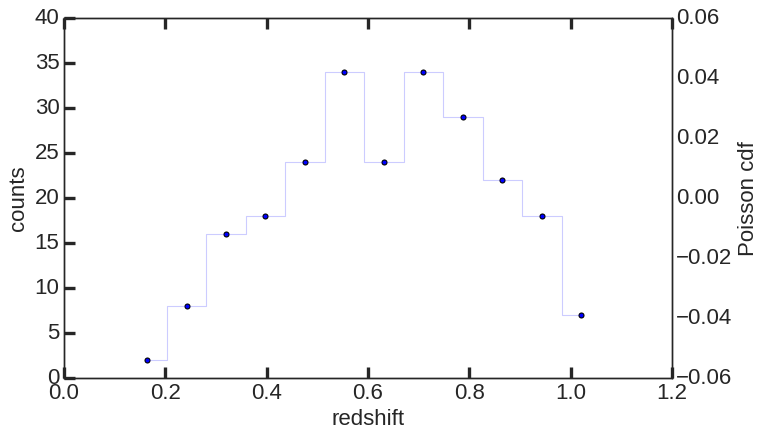

In [191]:
reload(baserate)

volume = baserate.VolumeVolumeModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(volume)
ratefitter.fit(a_guess = 0.2, b_guess = 0.3, zmax_guess = 0.7,
               b_fixed = True, zmax_fixed = True)
_ = ratefitter.show(add_proba = True)
volume.parammissed

/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:495: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0
/home/nora/installs/anaconda3/lib/python3.7/site-packages/modefit-0.2.4-py3.7.egg/modefit/baseobjects.py:1269: UserWarning: migrad is not valid
  warnings.warn("migrad is not valid")
/home/nora/installs/anaconda3/lib/python3.7/site-packages/modefit-0.2.4-py3.7.egg/modefit/baseobjects.py:1225: UserWarning: Inaccurate covariance Matrix. Only trace defined
  warnings.warn("Inaccurate covariance Matrix. Only trace defined")


{'b': 5316.234720963694, 'zmax': 0.7486620139677895, 'zc': 0.07845836687013252}

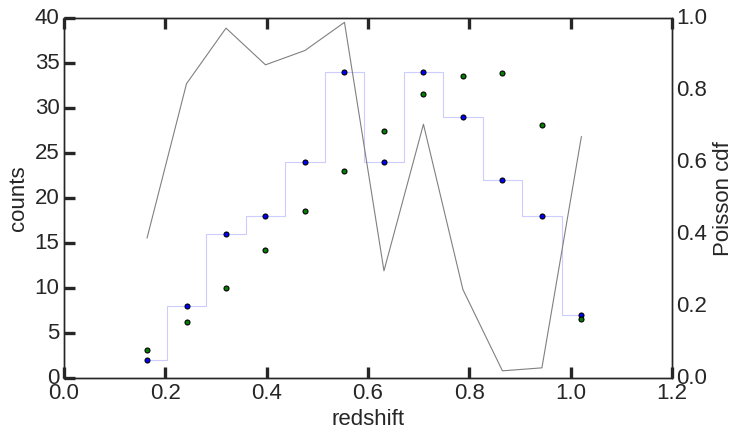

In [133]:
reload(baserate)

expo = baserate.VolumeExpoModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(expo)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2, b_guess = 1, zmax_guess = 0.7, zc_guess = 1e-1,\
               #b_fixed = True, zmax_fixed = True, zc_fixed = True\
              )
_ = ratefitter.show(add_proba = True)
expo.parammissed

## Const model

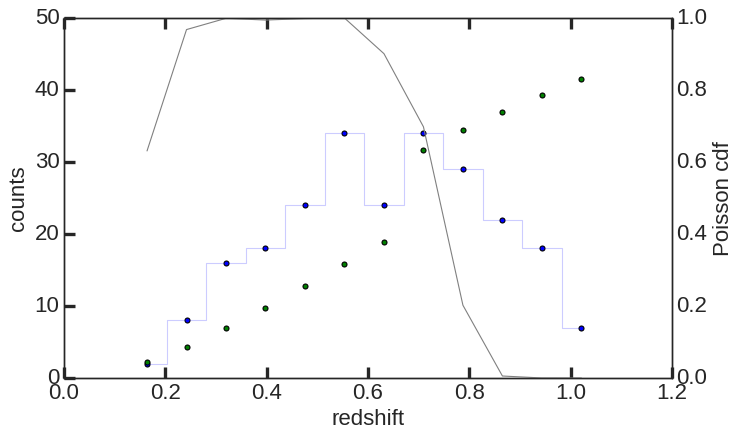

In [137]:
reload(baserate)

const = baserate.VolumeConstModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(const)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges<0.7)
ratefitter.fit(a_guess = 0.2, zmax_guess = 0.7,
               zmax_fixed = True)
_ = ratefitter.show(add_proba = True)